In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Concatenate
import matplotlib.animation as animation
from sklearn.preprocessing import MinMaxScaler

### 파라미터 설정

In [2]:
## m1, m2, m3
masses = np.array([1.0, 1.0, 1.0])

## k1, k2, k3, k4
spring_constants = np.array([2.0, 1.0, 1.0, 2.0])
n_masses = len(masses)
n_springs = len(spring_constants)

### 초기 조건 설정

In [7]:
## x1(0), x2(0), x3(0)
initial_positions = np.array([1, 0.5, 0])

## v1(0), v2(0), v3(0)
initial_velocities = np.zeros(n_masses)

initial_conditions = np.concatenate([initial_positions, initial_velocities])
print(initial_conditions)

[1.  0.5 0.  0.  0.  0. ]


### 학습 데이터 시간 설정

In [8]:
## 학습 데이터 시간 설정
t_span = [0, 10]  # 시간 범위 , 0 ~ 10[초]
t_eval = np.linspace(t_span[0], t_span[1], 200)
print(t_eval.shape)

(200,)


### 테스트 데이터 시간 설정

In [9]:
# 0 ~ 20[초], 0~10[초]는 학습 시간과 겹침 , 10~20[초] 테스트 데이터 시간
# 데이터 플롯팅 편의를 위해 설정

t_span_test = [0, 20]
t_eval_test = np.linspace(t_span_test[0], t_span_test[1], 400)
print(t_eval_test.shape)

(400,)


## Ground Truth 데이터 설정

In [10]:
# motion equation
def motion(t, y):
    positions = y[:n_masses]
    velocities = y[n_masses:]
    accelerations = np.zeros(n_masses)

    for i in range(n_masses):
        if i > 0:
            accelerations[i] -= spring_constants[i] * (positions[i] - positions[i-1]) / masses[i]
        if i < n_masses - 1:
            accelerations[i] += spring_constants[i+1] * (positions[i+1] - positions[i]) / masses[i]

    accelerations[0] -= spring_constants[0] * positions[0] / masses[0]
    accelerations[-1] += spring_constants[-1] * (0 - positions[-1]) / masses[-1]

    return np.concatenate([velocities, accelerations])

In [11]:
solution = solve_ivp(motion, t_span, initial_conditions, t_eval=t_eval, method='RK45')
solution_test = solve_ivp(motion, t_span_test, initial_conditions, t_eval=t_eval_test, method='RK45')

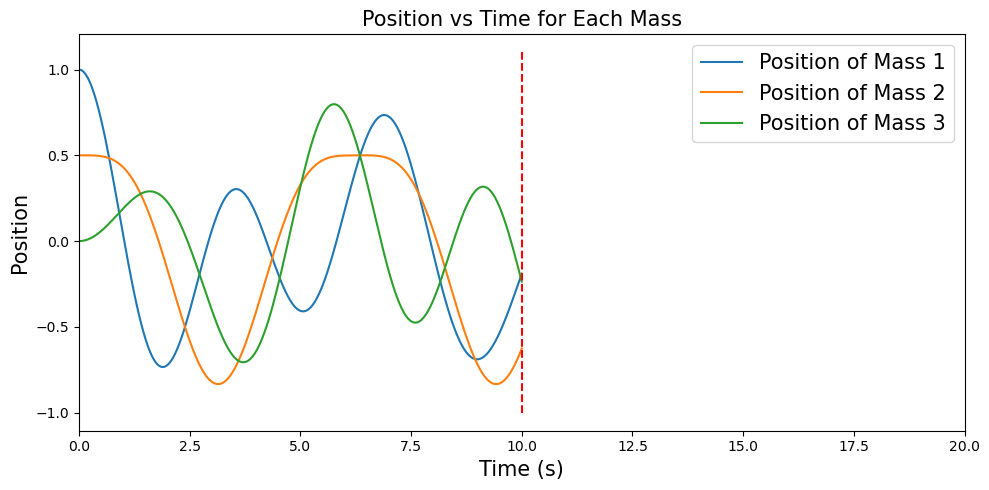

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Position graphs for each mass
for i in range(n_masses):
    axs.plot(t_eval, solution.y[i], label=f'Position of Mass {i+1}')
axs.set_xlabel('Time (s)', fontsize = 15)
axs.set_ylabel('Position', fontsize = 15)
axs.set_title('Position vs Time for Each Mass', fontsize = 15)
axs.vlines(10, -1, 1.1, color='red',linestyle='--')
axs.legend(fontsize = 15, loc='upper right')
axs.set_xlim([0,20])
plt.xlim([0,20])
plt.tight_layout()
plt.show()

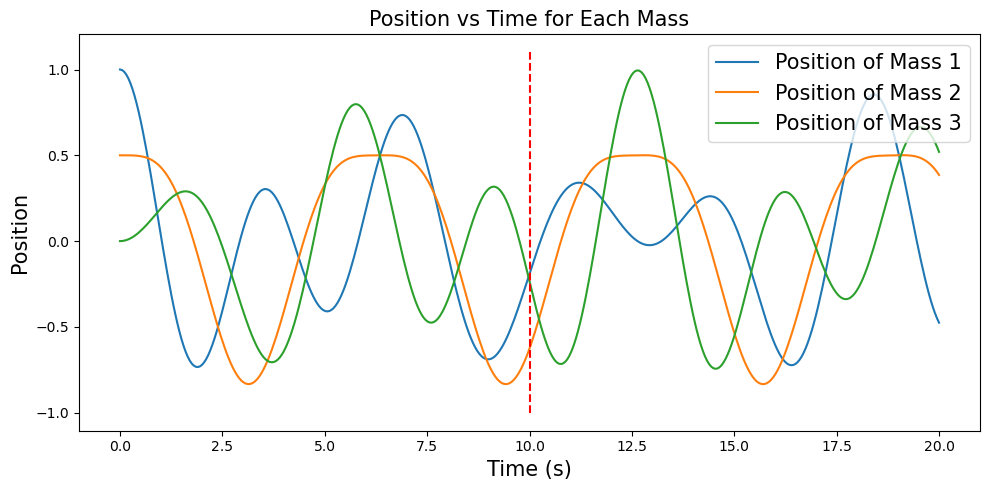

In [13]:
############################ TEST data ################################
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Position graphs for each mass
for i in range(n_masses):
    axs.plot(t_eval_test, solution_test.y[i], label=f'Position of Mass {i+1}')
axs.set_xlabel('Time (s)', fontsize = 15)
axs.set_ylabel('Position', fontsize = 15)
axs.set_title('Position vs Time for Each Mass', fontsize = 15)
axs.legend(fontsize = 15, loc='upper right')
axs.vlines(10, -1, 1.1, color='red',linestyle='--')


plt.tight_layout()
plt.show()

### GT 데이터 생성

In [19]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [20]:
#########################
train_window = 10
#########################

data = solution.y[:3].T
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(data)
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

X_train = np.array([seq[0] for seq in train_inout_seq])
y_train = np.array([seq[1] for seq in train_inout_seq]).squeeze()
print(X_train.shape, y_train.shape)

(190, 10, 3) (190, 3)


In [37]:
'''
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Position graphs for each mass
for i in range(n_masses):
    axs.plot(t_eval, solution.y[i], alpha = 0.3, color = 'black')
    # axs.plot(t_eval[140:150], solution.y[i][140:150], label=f'Position of Mass {i+1}')
    axs.plot(t_eval[140:150], solution.y[i][140:150], label=f'x{i+1}(t)')
axs.set_xlabel('Time (s)', fontsize = 15)
axs.set_ylabel('Position', fontsize = 15)
axs.set_title('Position vs Time for Each Mass', fontsize = 15)
axs.legend(fontsize = 15, loc='upper right')
axs.vlines(7, -1, 1.1, color='red',linestyle='--')
axs.vlines(7.5, -1, 1.1, color='red',linestyle='--')
# # Velocity graphs for each mass
# for i in range(n_masses):
#     axs[1].plot(t_eval, solution.y[i + n_masses], label=f'Velocity of Mass {i+1}')
# axs[1].set_xlabel('Time (s)', fontsize = 15)
# axs[1].set_ylabel('Velocity', fontsize = 15)
# axs[1].set_title('Velocity vs Time for Each Mass', fontsize = 15)
# axs[1].legend(fontsize = 15, loc='upper right')
plt.xlim([0,11])
plt.ylim([-1,1.1])
plt.tight_layout()
plt.show()
'''

"\nfig, axs = plt.subplots(1, 1, figsize=(10, 4))\n\n# Position graphs for each mass\nfor i in range(n_masses):\n    axs.plot(t_eval, solution.y[i], alpha = 0.3, color = 'black')\n    # axs.plot(t_eval[140:150], solution.y[i][140:150], label=f'Position of Mass {i+1}')\n    axs.plot(t_eval[140:150], solution.y[i][140:150], label=f'x{i+1}(t)')\naxs.set_xlabel('Time (s)', fontsize = 15)\naxs.set_ylabel('Position', fontsize = 15)\naxs.set_title('Position vs Time for Each Mass', fontsize = 15)\naxs.legend(fontsize = 15, loc='upper right')\naxs.vlines(7, -1, 1.1, color='red',linestyle='--')\naxs.vlines(7.5, -1, 1.1, color='red',linestyle='--')\n# # Velocity graphs for each mass\n# for i in range(n_masses):\n#     axs[1].plot(t_eval, solution.y[i + n_masses], label=f'Velocity of Mass {i+1}')\n# axs[1].set_xlabel('Time (s)', fontsize = 15)\n# axs[1].set_ylabel('Velocity', fontsize = 15)\n# axs[1].set_title('Velocity vs Time for Each Mass', fontsize = 15)\n# axs[1].legend(fontsize = 15, loc='up

### Create LSTM model

In [45]:
# Build LSTM model with Keras
lstm_latent_size = 100
dense_hidden_size = 100

# model = Sequential()
# model.add(LSTM(lstm_latent_size, input_shape=(None, 3), return_sequences=True))
# model.add(LSTM(lstm_latent_size, activation = 'tanh'))
# model.add(Dense(dense_hidden_size, activation = 'tanh'))
# model.add(Dense(3, activation = 'tanh'))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

model = Sequential()
model.add(LSTM(lstm_latent_size, input_shape=(train_window, 3), return_sequences=True))
model.add(LSTM(lstm_latent_size, activation = 'tanh', return_sequences=False))
model.add(Dense(dense_hidden_size, activation = 'tanh'))
model.add(Dense(3, activation = 'tanh'))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 100)           41600     
                                                                 
 lstm_12 (LSTM)              (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 3)                 303       
                                                                 
Total params: 132,403
Trainable params: 132,403
Non-trainable params: 0
_________________________________________________________________


### Train model

In [46]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
6/6 [==============================] - 2s 13ms/step - loss: 0.2738
Epoch 2/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0685
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0497
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 5/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0320
Epoch 6/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0272
Epoch 7/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 8/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 9/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0216
Epoch 10/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 11/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0185
Epoch 12/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 13/50
6/6 [==============================] - 0s 4ms/step - loss:

#### 학습 곡선

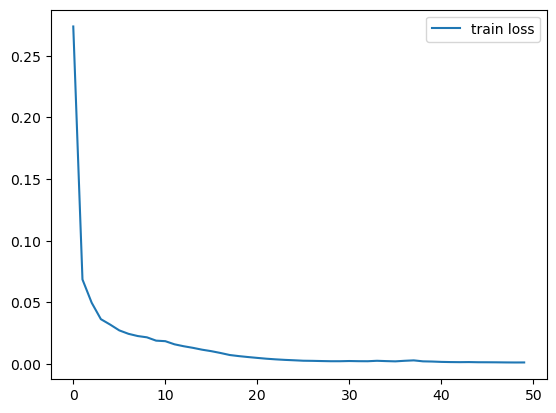

In [47]:
plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

### 모델 성능 평가

In [75]:
## solution_test 학습, 테스트 데이터 섞여 있음
data_all = solution_test.y[:3].T
data_all_normalized = scaler.fit_transform(data_all)

data_train = data_all_normalized[:200]
data_test = data_all_normalized[200:]

In [76]:
data_test.shape

(200, 3)

In [77]:
## prediction for test data
test_seq = data_train[200-train_window:]
for i in range(200):
    pred = model.predict(test_seq[i:][np.newaxis], verbose=0)
    test_seq = np.concatenate([test_seq, pred], axis=0).squeeze()

## prediction trajectory
pred_test_traj = scaler.inverse_transform(test_seq.reshape(-1,3))

In [78]:
pred_traj = np.concatenate([data_train, pred_test_traj[train_window:], ], axis=0)

In [79]:
pred_traj.shape

(400, 3)

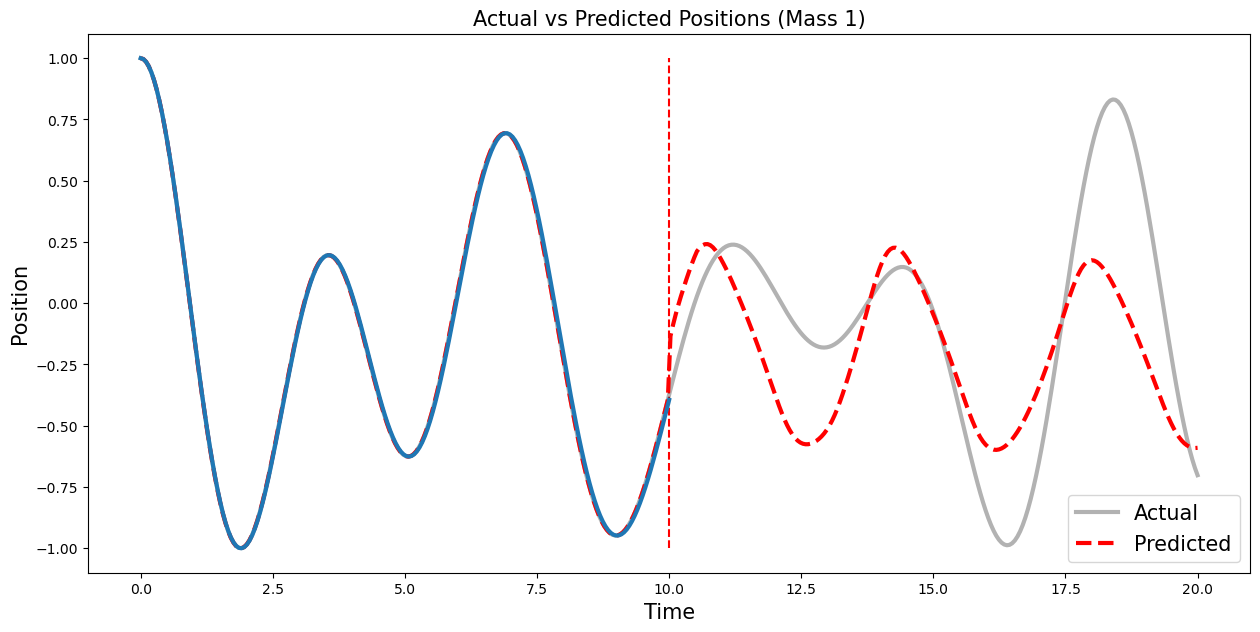

In [88]:
## plot for mass #1
mass_n  = 2  # 1, 2, 3
mass_n -= 1  # 0, 1, 2

data_test = data_all_normalized

plt.figure(figsize=(15,7))
plt.vlines(10,-1,1, color = 'red', linestyle='--')
plt.plot(t_eval_test, data_test[:,mass_n], label='Actual', linewidth = 3, color='black',alpha=0.3)
plt.plot(t_eval_test, pred_traj[:,mass_n],
         label='Predicted', linestyle='--', linewidth =3, color = 'red')
# plt.plot(t_eval, solution.y[0], linewidth = 3)
plt.plot(t_eval, data_train[:,mass_n], linewidth = 3)
plt.title('Actual vs Predicted Positions (Mass 1)', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Position', fontsize = 15)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = 15)
plt.show()

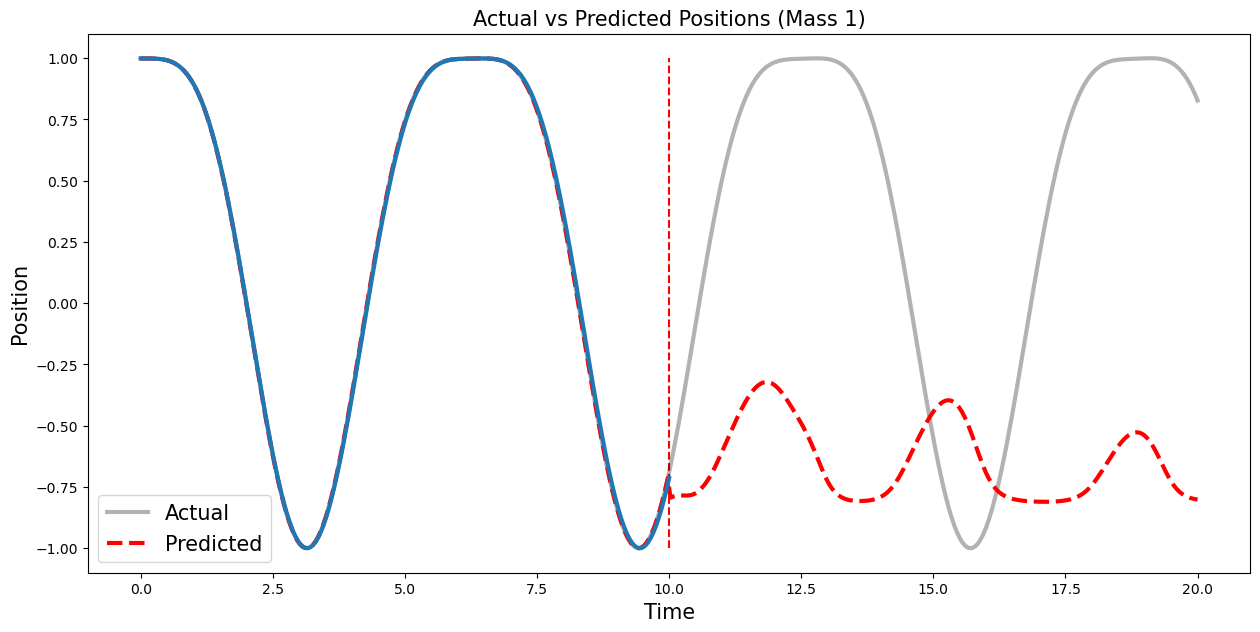

In [92]:
## plot for mass #2
mass_n  = 2  # 1, 2, 3
mass_n -= 1  # 0, 1, 2

data_test = data_all_normalized

plt.figure(figsize=(15,7))
plt.vlines(10,-1,1, color = 'red', linestyle='--')
plt.plot(t_eval_test, data_test[:,mass_n], label='Actual', linewidth = 3, color='black',alpha=0.3)
plt.plot(t_eval_test, pred_traj[:,mass_n],
         label='Predicted', linestyle='--', linewidth =3, color = 'red')
# plt.plot(t_eval, solution.y[0], linewidth = 3)
plt.plot(t_eval, data_train[:,mass_n], linewidth = 3)
plt.title('Actual vs Predicted Positions (Mass 1)', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Position', fontsize = 15)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = 15)
plt.show()

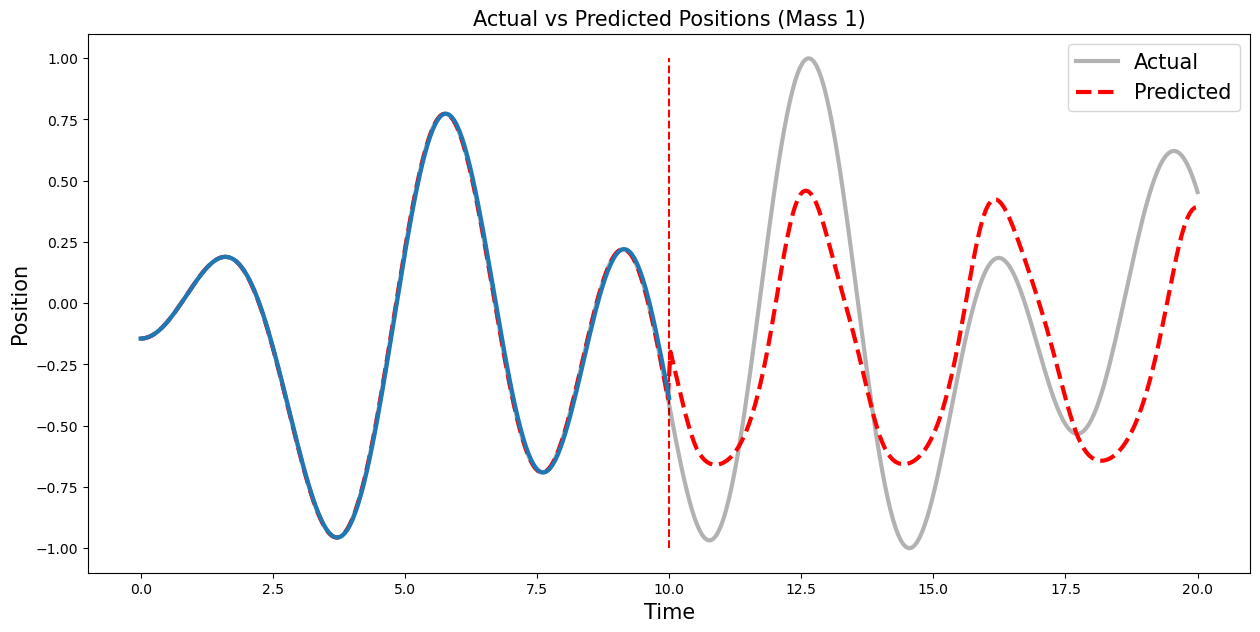

In [93]:
## plot for mass #2
mass_n  = 3  # 1, 2, 3
mass_n -= 1  # 0, 1, 2

data_test = data_all_normalized

plt.figure(figsize=(15,7))
plt.vlines(10,-1,1, color = 'red', linestyle='--')
plt.plot(t_eval_test, data_test[:,mass_n], label='Actual', linewidth = 3, color='black',alpha=0.3)
plt.plot(t_eval_test, pred_traj[:,mass_n],
         label='Predicted', linestyle='--', linewidth =3, color = 'red')
# plt.plot(t_eval, solution.y[0], linewidth = 3)
plt.plot(t_eval, data_train[:,mass_n], linewidth = 3)
plt.title('Actual vs Predicted Positions (Mass 1)', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Position', fontsize = 15)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = 15)
plt.show()

## Method 2 : Coupled Spring Mass ODE System (PINN)

In [94]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("pytorch")

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.




Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [95]:
# Masses
m1 = 1.0
m2 = 1.0
m3 = 1.0

# Spring constants
k1 = 2.0
k2 = 1.0
k3 = 1.0
k4 = 2.0


# Initial conditions
# Initial displacements (from equilibrium positions)
d1_0 = 1
d2_0 = 0
d3_0 = 0

# Initial velocities
v1_0 = 0.0
v2_0 = 0.0
v3_0 = 0.0

# Maximum time to simulate
t_max = 5

<b> Note : Equations of Motion </b>

$$
\begin{cases}
m_1 \ddot{x}_1(t) &= -k_1 x_1(t) + k_2 \left( x_2(t) - x_1(t) \right), \\
m_2 \ddot{x}_2(t) &= -k_2 \left( x_2(t) - x_1(t) \right) + k_3 \left( x_3(t) - x_2(t) \right), \\
m_3 \ddot{x}_3(t) &= -k_3 \left( x_3(t) - x_2(t) \right) - k_4 x_3(t).
\end{cases}
$$

In [98]:
def dy(t, x):
    return dde.grad.jacobian(x, t)

def pde(t, x):
    # mass 1 location
    x_1 = x[:, 0:1] # Use slicing to extract the column as a tensor
    # mass 2 location
    x_2 = x[:, 1:2] # Use slicing to extract the column as a tensor
    # mass 3 location
    x_3 = x[:, 2:3] # Use slicing to extract the column as a tensor

    dx1_tt = dde.grad.hessian(x, t, i=0,j=0,component=0)
    dx2_tt = dde.grad.hessian(x, t, i=0,j=0,component=1)
    dx3_tt = dde.grad.hessian(x, t, i=0,j=0,component=2)

    pde1 = m1 * dx1_tt + k1 * (x_1) - k2 * (x_2 - x_1)
    pde2 = m2 * dx2_tt + k2 * (x_2 - x_1) - k3 * (x_3 - x_2)
    pde3 = m3 * dx3_tt + k3 * (x_3 - x_2) - k4 * (x_3)

    return [pde1, pde2, pde3]

In [96]:
def boundary_init(t, on_boundary):
    return on_boundary and np.isclose(t[0], 0)

geom = dde.geometry.Interval(0, t_max)

init_d1 = dde.icbc.PointSetBC(np.array([0]), np.array([d1_0]).reshape(-1, 1), component=0)
init_d2 = dde.icbc.PointSetBC(np.array([0]), np.array([d2_0]).reshape(-1, 1), component=1)
init_d3 = dde.icbc.PointSetBC(np.array([0]), np.array([d3_0]).reshape(-1, 1), component=2)

init_v1 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y[:, 0:1]), boundary_init)
init_v2 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y[:, 1:2]), boundary_init)
init_v3 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y[:, 2:3]), boundary_init)

In [99]:
data = dde.data.PDE(
    geom,
    pde,
    [init_d1, init_d2, init_d3, init_v1, init_v2, init_v3],
    num_domain=2000,
    num_boundary=100,
    num_test=1000
)

In [100]:
layer_size = [1] + [20] * 3 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.047302 s



c:\Users\ksjhm\miniconda3\envs\ai-for-me\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.745350 s



In [101]:
losshistory, train_state = model.train(epochs=5000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [7.01e-01, 4.48e-02, 1.88e-01, 1.00e+00, 0.00e+00, 0.00e+00, 6.62e-02, 6.21e-02, 2.85e-02]    [7.07e-01, 4.49e-02, 1.91e-01, 1.00e+00, 0.00e+00, 0.00e+00, 6.62e-02, 6.21e-02, 2.85e-02]    []  
1000      [7.69e-02, 4.47e-02, 5.55e-03, 3.09e-02, 4.27e-03, 1.15e-03, 9.41e-05, 2.14e-06, 4.12e-04]    [7.96e-02, 4.22e-02, 4.80e-03, 3.09e-02, 4.27e-03, 1.15e-03, 9.41e-05, 2.14e-06, 4.12e-04]    []  
2000      [2.18e-02, 1.16e-02, 1.86e-03, 5.71e-03, 9.26e-04, 7.18e-04, 1.32e-04, 1.14e-04, 3.24e-04]    [2.06e-02, 9.63e-03, 1.61e-03, 5.71e-03, 9.26e-04, 7.18e-04, 1.32e-04, 1.14e-04, 3.24e-04]    []  
3000      [9.94e-05, 1.71e-04, 7.05e-04, 9.49e-06, 3.53e-05, 4.39e-04, 1.64e-06, 2.60e-05, 3.25e-04]    [9.06e-05, 1.77e-04, 7.06e-04, 9.49e-06, 3.53e-05, 4.39e-0

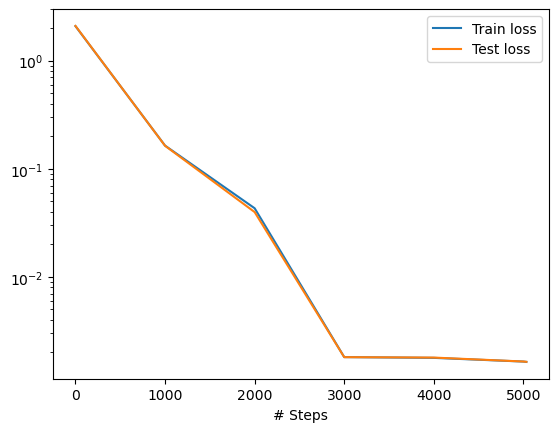

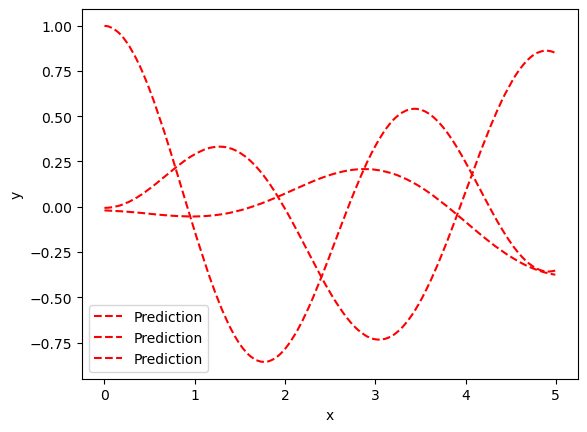

In [105]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

#### compare result with scipy ode solver solution

In [109]:
from scipy.integrate import odeint

# Define the differential equations for the coupled spring-mass system for ODE solver
def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,k4,L1,L2,L3,L4]
    """
    x1, y1, x2, y2, x3, y3 = w
    m1, m2, m3, k1, k2, k3, k4 = p

    # Create f = (x1',y1',x2',y2',x3',y3'):
    f = [y1,
         (-k1 * (x1) + k2 * (x2 - x1)) / m1,
         y2,
         (-k2 * (x2 - x1) + k3 * (x3 - x2)) / m2,
         y3,
         (-k3 * (x3 - x2) - k4 * (x3)) / m3]
    return f

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = t_max
numpoints = 250

t = geom.random_points(5000)

t[:,0].sort()

# Pack up the parameters and initial conditions:
p = [m1, m2, m3, k1, k2, k3, k4]
w0 = [d1_0, v1_0, d2_0, v2_0, d3_0, v3_0]

# Call the ODE solver.
wsol = odeint(vectorfield, w0, t[:,0], args=(p,), atol=abserr, rtol=relerr)

In [110]:
# Predict using the PINN trained model
pinn_result = model.predict(t)
result = pinn_result

In [111]:
## PINN result
usol1 = np.array(result[:, 0]) # x1
usol2 = np.array(result[:, 1]) # x2
usol3 = np.array(result[:, 2]) # x3

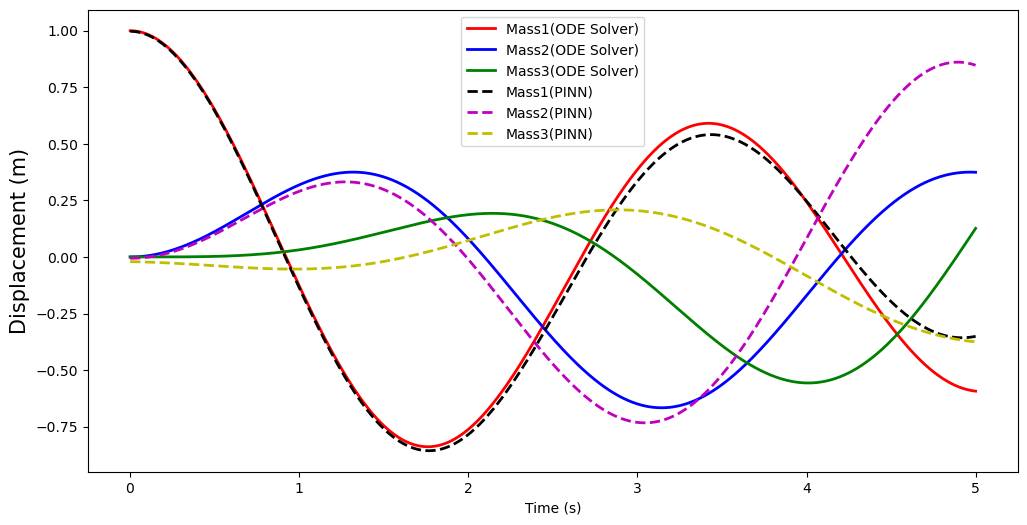

In [117]:
# Plot the results
lw = 2
plt.figure(figsize=(12, 6))
plt.plot(t, wsol[:, 0], alpha=1, label='Mass1(ODE Solver)', c='r', lw=lw)
plt.plot(t, wsol[:, 2], alpha=1, label='Mass2(ODE Solver)', c='b', lw=lw)
plt.plot(t, wsol[:, 4], alpha=1, label='Mass3(ODE Solver)', c='g', lw=lw)
plt.plot(t, usol1, alpha=1, label='Mass1(PINN)', linestyle='dashed', c='k', lw=lw)
plt.plot(t, usol2, alpha=1, label='Mass2(PINN)', linestyle='dashed', c='m', lw=lw)
plt.plot(t, usol3, alpha=1, label='Mass3(PINN)', linestyle='dashed', c='y', lw=lw)
plt.legend(loc="upper center",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Displacement (m)', fontsize=15)
plt.show()